We'll be using the Ipopt solver. It's one of the "best" solvers in that it'll do most linear and non-linear problems fairly quickly.

In this case, we'll be solving both an LP (linear programming) and QCP (Quadratically Constrained Problem).

In [1]:
using GamsStructure
using JuMP
using Ipopt

Load the data. I've skipped the downloading and cleaning. It's all provided.

In [2]:
GU = GamsUniverse()

@GamsSets(GU,"data",begin
    :yr, "Years"
    :m, "Months"
    :dm, "Days"
end)

@GamsParameters(GU,"data",begin
    :tavg, (:yr,:m,:dm), "Average Tempurates", [1,2,3]
    :day, (:yr,:m,:dm), "Day (integer) associated with dates (Jan 1, 1900 = 1)", [1,2,3]
end)


1;

# L1 Model

This is set up as a function for a few reasons

1. More reusable. 
2. The way Julia's compiler works, functions tend to be faster on reuse.

In [3]:
function calib(GU)

    model = Model(Ipopt.Optimizer)

    set_silent(model) #supress model output. Comment this out to see it

    YR = GU[:yr]
    M = GU[:m]
    DM = GU[:dm]

    @variables(model,begin
        DEV[YR,M,DM]>=0
        T[YR,M,DM]
        X0
        X1
        X2
        X3
        X4
        X5
    end)


    @objective(model,Min, sum(DEV))


    @constraint(model,tdef[yr=YR,m=M,dm=DM;GU[:tavg][[yr],[m],[dm]]≠0],
        T[yr,m,dm] == X0 +  X1*GU[:day][[yr],[m],[dm]] + X2*cos(2*pi*GU[:day][[yr],[m],[dm]]/365.25) + X3*sin(2*pi*GU[:day][[yr],[m],[dm]]/365.25)
        + X4*cos(2*pi*GU[:day][[yr],[m],[dm]]/(10.7*365.25)) + X5*sin(2*pi*GU[:day][[yr],[m],[dm]]/(10.7*365.25)) 
    )


    @constraint(model,devlb[yr=YR,m=M,dm=DM;GU[:tavg][[yr],[m],[dm]]≠0],
        DEV[yr,m,dm] >= GU[:tavg][[yr],[m],[dm]]/10 - T[yr,m,dm]
    )

    @constraint(model,devub[yr=YR,m=M,dm=DM;GU[:tavg][[yr],[m],[dm]]≠0],
        DEV[yr,m,dm] >= T[yr,m,dm] - GU[:tavg][[yr],[m],[dm]]/10
    )

    return model
end

l1_model = calib(GU)

optimize!(l1_model)

solution_summary(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



UndefVarError: UndefVarError: model not defined

# L2 Model

There are no constraints in this model. Everything is in the objective. This turns out to be faster.

In [4]:
function calibL2(GU)

    model = Model(Ipopt.Optimizer)

    set_silent(model) #supress model output. Comment this out to see it

    YR = GU[:yr]
    M = GU[:m]
    DM = GU[:dm]

    @variables(model,begin
        X0
        X1
        X2
        X3
        X4
        X5
    end)


    @objective(model,Min, 

        sum( (X0 +  X1*GU[:day][[yr],[m],[dm]] 
                 + X2*cos(2*pi*GU[:day][[yr],[m],[dm]]/365.25) 
                 + X3*sin(2*pi*GU[:day][[yr],[m],[dm]]/365.25)
                 + X4*cos(2*pi*GU[:day][[yr],[m],[dm]]/(10.7*365.25)) 
                 + X5*sin(2*pi*GU[:day][[yr],[m],[dm]]/(10.7*365.25))
                 - GU[:tavg][[yr],[m],[dm]]/10)^2 
                 for yr∈YR,m∈M,dm∈DM if GU[:tavg][[yr],[m],[dm]]≠0   
    ))

    return model
end

l2_model = calibL2(GU)

optimize!(l2_model)

#solution_summary(model)

A quick way to print the variables and view solutions

In [5]:
variables = [:X0,:X1,:X2,:X3,:X4,:X5]

l1 = Dict()
l2 = Dict()

for var in variables
    println("$var -> L1: $(value(l1_model[var])) -> L2: $(value(l2_model[var]))")

    l1[var] = value(l1_model[var])
    l2[var] = value(l2_model[var])
end

X0 -> L1: 13.428558929588432 -> L2: 13.402353411768047
X1 -> L1: 1.421409582601236e-5 -> L2: 1.8748310166604454e-5
X2 -> L1: 5.127401044037989 -> L2: 5.151329674486196
X3 -> L1: -14.613665504789864 -> L2: -14.845016590609573
X4 -> L1: -0.01912238287343617 -> L2: -0.09235696899965422
X5 -> L1: -0.05268925576956353 -> L2: -0.049849826390442026


# Displaying Data

After this portion, we're going to make the graphs Tom makes in Excel using Julia. If you are familiar with Python Pandas, this will be very familiar with a few syntax changes into Julia DataFrames.

One big change is that column labels are symbols in Julia. Whenever you see something like

:year

That is a symbol, the : designates a symbol. What is a symbol? It's like a special string, but faster than a string. If you use Julia you'll use Symbols a lot.

In [6]:
using Plots
using DataFrames

Create the dataframes. 

In [71]:
years = DataFrame(year = parse.(Int,[String(e) for e in GU[:yr]])) #The years are symbols, convert to ints, which they should be.
months = DataFrame(month = parse.(Int,[String(e) for e in GU[:m]]))
days = DataFrame(day = parse.(Int,[String(e) for e in GU[:dm]]))

df = crossjoin(years,months,days) #cross product


#Create empty columns
for cols in [:day_num,:Actual,:Tl1,:Tl2,:GWl1,:GWl2,:AnnualL1,:AnnualL2]
    df[!,cols] = Vector{Union{Float64, Nothing}}(nothing, size(df, 1)) #Julia is a strongly typed language. That's why the union non-sense is there
end

for row in eachrow(df) #iterate over the rows of the dataframe. 
    yr = Symbol(row[:year])
    month = Symbol(row[:month])
    day_ = Symbol(row[:day])

    day = GU[:day][[yr],[month],[day_]]

    row[:day_num] = day
    row[:Actual] = GU[:tavg][[yr],[month],[day_]]/10


    row[:Tl1] = (l1[:X0] + l1[:X1]*day 
                        + l1[:X2]*cos(2*pi*day/365.25)
                        + l1[:X3]*sin(2*pi*day/365.25)
                        + l1[:X4]*cos(2*pi*day/(10.7*365.25))
                        + l1[:X5]*sin(2*pi*day/(10.7*365.25)))

    


    row[:Tl2] = (l2[:X0] + l2[:X1]*day 
                        + l2[:X2]*cos(2*pi*day/365.25)
                        + l2[:X3]*sin(2*pi*day/365.25)
                        + l2[:X4]*cos(2*pi*day/(10.7*365.25))
                        + l2[:X5]*sin(2*pi*day/(10.7*365.25)))



    #You can fill out the columns here. I got sick of it.
end


sort!(df,[:day_num]) #due to the way the data is going to be plotted, we need to sort by the day

1;

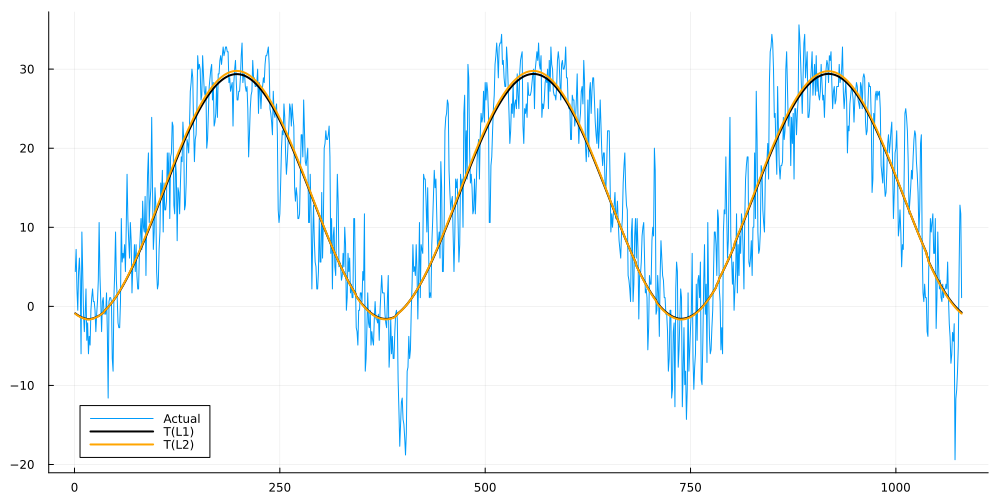

In [80]:
function pivot_filter(year,actual)
    yr = year∈[2020,2021,2022] #You can add years here
    a = actual≠0
    return yr && a
end


ndf = filter([:year,:Actual] => pivot_filter,df) #This will take the two identified columns [:year,:Actual] and put them into the pivot_filter function

plot(ndf[!,:Actual],label = "Actual",size=(1000,500))

plot!(ndf[!,:Tl1],label = "T(L1)",color=:black,linewidth=2)
plot!(ndf[!,:Tl2],label = "T(L2)",color=:orange,linewidth=2)